Ce notebook est le dernier du processus de traitement des donn√©es.
Il permet de r√©aliser diff√©rentes analyses statistiques sur les donn√©es du corpus, pr√©alablement automomatiquement annot√©es, ainsi que sur les donn√©es du coprus t√©moin. Le notebook comprend diverses analyses comme le calcul de moyennes, ou encore la production de nombreuses figures, tableaux et graphiques.

Ce notebook a √©t√© produit dans Google colab.

In [2]:
import pandas as pd

In [51]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import UnivariateSpline
from scipy.signal import medfilt

On commence par renseigner puis importer les chemins des deux fichiers csv :

In [1]:
mon_fichier_path = '/content/annos_emo_expert_vdef.csv'
mon_fichier_temoin_path = '/content/fichier_complet_temoin.csv'

In [3]:
mon_fichier = pd.read_csv(mon_fichier_path, on_bad_lines='skip')
mon_fichier_temoin = pd.read_csv(mon_fichier_temoin_path, on_bad_lines='skip')

mon_fichier

Unnamed: 0                                           title  \
0              0   climat_corona_et_caetera_henri_de_lesquen.txt   
1              1   climat_corona_et_caetera_henri_de_lesquen.txt   
2              2   climat_corona_et_caetera_henri_de_lesquen.txt   
3              3   climat_corona_et_caetera_henri_de_lesquen.txt   
4              4   climat_corona_et_caetera_henri_de_lesquen.txt   
...          ...                                             ...   
2394        2394  yves_roucaute_sur_cnews_raphael_dragonneau.txt   
2395        2395  yves_roucaute_sur_cnews_raphael_dragonneau.txt   
2396        2396  yves_roucaute_sur_cnews_raphael_dragonneau.txt   
2397        2397  yves_roucaute_sur_cnews_raphael_dragonneau.txt   
2398        2398  yves_roucaute_sur_cnews_raphael_dragonneau.txt   

                                                content     score  \
0     Je suis fier d'√™tre √† la t√™te d'un grand mouve...  0.407600   
1     Le 26 f√©vrier 2020, le PSG a jou√© au pied √† Ly...  0.684093   
2     Le soir m√™me, jeudi 12 mars, sans plus attendr...  0.551490   
3     En 2004, c'est encore mieux. De plus en plus f...  0.913224   
4     Passons sur le fait que ces statistiques sont ...  0.767427   
...                                                 ...       ...   
2394  Voici le texte corrig√© :\n\n"Par exemple, ils ...  0.961186   
2395  Je veux dire, je vais vous donner deux ou troi...  0.812702   
2396  Et bien avant la derni√®re glaciation, donc il ...  0.619478   
2397  C'est absolument incroyable, c'est fascinant c...  0.743721   
2398  Parce que √©cologiste, √ßa vient d'oikos en grec...  0.589650   

      score_echelle                                    score_par_label  \
0                 1  sad: 0.3099, fear: 0.0083, anger: 0.4076, neut...   
1                 2  sad: 0.1762, fear: 0.0697, anger: 0.6841, neut...   
2                 2  sad: 0.4262, fear: 0.0081, anger: 0.5515, neut...   
3                 3  sad: 0.0692, fear: 0.0097, anger: 0.9132, neut...   
4                 3  sad: 0.2059, fear: 0.0092, anger: 0.7674, neut...   
...             ...                                                ...   
2394              1  sad: 0.0100, fear: 0.0040, anger: 0.0096, neut...   
2395              3  sad: 0.8127, fear: 0.0023, anger: 0.1539, neut...   
2396              1  sad: 0.2568, fear: 0.0122, anger: 0.0317, neut...   
2397              2  sad: 0.0263, fear: 0.0498, anger: 0.0366, neut...   
2398              2  sad: 0.3766, fear: 0.0099, anger: 0.5896, neut...   

      sum_without_neutral  sum_recalibree label_dominant  intensite_emotion  \
0                  0.9238        8.679721          anger                  2   
1                  0.9687        7.345752          anger                  2   
2                  0.9901        5.284120          anger                  2   
3                  0.9981        4.022855          anger                  2   
4                  0.9894        4.534043          anger                  2   
...                   ...             ...            ...                ...   
2394               0.0387        0.670930        neutral                  1   
2395               0.9707        6.449467            sad                  2   
2396               0.3805        4.555210        neutral                  1   
2397               0.9264       28.496339       surprise                  3   
2398               0.9834        5.212679          anger                  2   

     score_vf  expertise_gpt4  
0           2             3.0  
1           3             3.0  
2           3             3.0  
3           2             3.0  
4           2             3.0  
...       ...             ...  
2394        1             3.0  
2395        2             3.0  
2396        1             3.0  
2397        3             3.0  
2398        2             3.0  

[2399 rows x 12 columns]

On effectue d'abord une premi√®re √©tape de nettoyager, pour supprimer les cases vides, et passer toutes les valeurs num√©riques au m√™me format int.

In [10]:
# les colonnes qui contiennent un NaN ou une valeur non enti√®re sont supprim√©es :
mon_fichier = mon_fichier.replace([float('inf'), float('-inf')], float('nan')).dropna(subset=['expertise_gpt4'])

# On convertit tout en int, et les colonnes pour lesquelles la conversion est manqu√©e sont supprim√©es :
mon_fichier['score_vf'] = pd.to_numeric(mon_fichier['score_vf'], errors='coerce')
mon_fichier = mon_fichier.dropna(subset=['score_vf']) # Drop rows where conversion failed
mon_fichier['expertise_gpt4'] = mon_fichier['expertise_gpt4'].astype(int)
mon_fichier['score_vf'] = mon_fichier['score_vf'].astype(int)

**1. Calcul des moyennes**

D'abord pour le corpus principal :

In [12]:
moyenne_emo = mon_fichier['score_vf'].mean()
moyenne_exp = mon_fichier['expertise_gpt4'].mean()
print("la moyenne de l'√©motion est : ", moyenne_emo)
print("la moyenne de l'expertise est : ", moyenne_exp)

la moyenne de l'√©motion est :  1.7944120100083403
la moyenne de l'expertise est :  2.2789824854045038


Ensuite pour le corpus t√©moin :

In [13]:
moyenne_emo = mon_fichier_temoin['score_vf'].mean()
moyenne_exp = mon_fichier_temoin['expertise_gpt4'].mean()
print("la moyenne de l'√©motion est : ", moyenne_emo)
print("la moyenne de l'expertise est : ", moyenne_exp)

la moyenne de l'√©motion est :  1.4437052200614124
la moyenne de l'expertise est :  2.097022587268994


**2. R√©partition des donn√©es  :**

Pour le corpus principal :

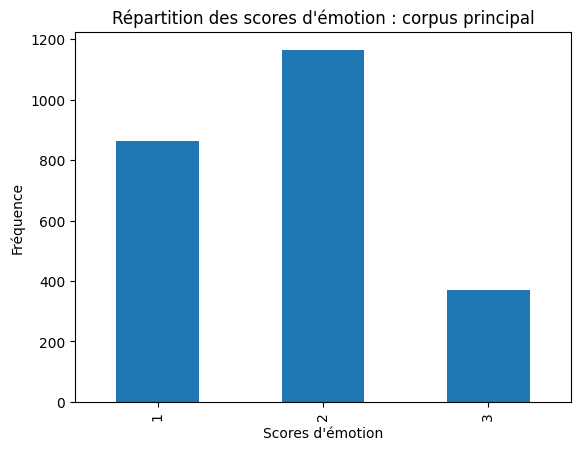

In [20]:
mon_fichier['score_vf'].value_counts().sort_index().plot(
    kind="bar"
)

plt.xlabel("Scores d'√©motion")
plt.ylabel("Fr√©quence")
plt.title("R√©partition des scores d'√©motion : corpus principal")
plt.show()

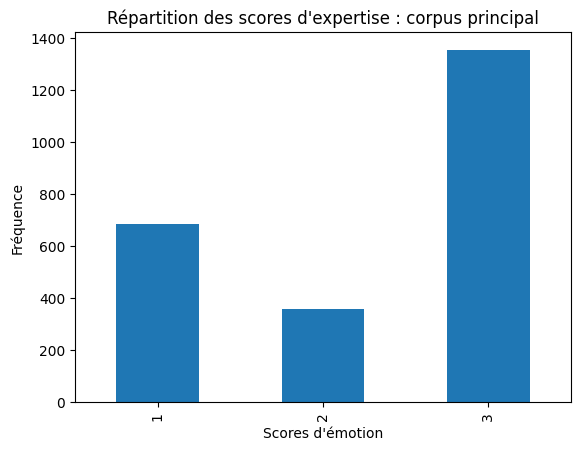

In [21]:
mon_fichier['expertise_gpt4'].value_counts().sort_index().plot(
    kind="bar"
)

plt.xlabel("Scores d'√©motion")
plt.ylabel("Fr√©quence")
plt.title("R√©partition des scores d'expertise : corpus principal")
plt.show()

A pr√©sent, on peut produire des diagrammes de r√©partition pour le corpus t√©moin :

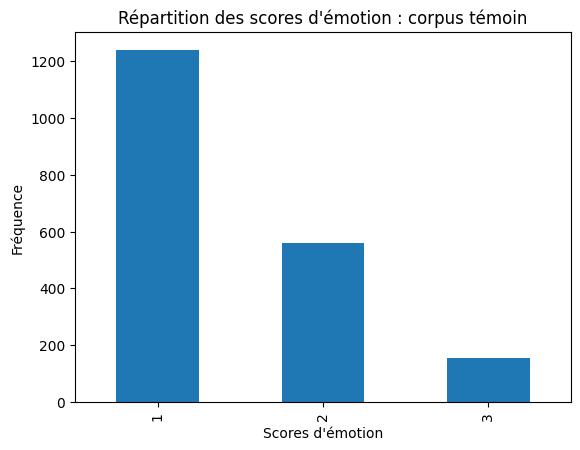

In [22]:
mon_fichier_temoin['score_vf'].value_counts().sort_index().plot(
    kind="bar"
)

plt.xlabel("Scores d'√©motion")
plt.ylabel("Fr√©quence")
plt.title("R√©partition des scores d'√©motion : corpus t√©moin")
plt.show()

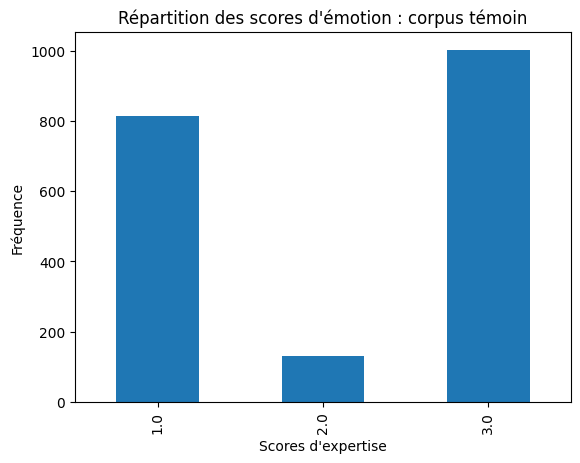

In [23]:
mon_fichier_temoin['expertise_gpt4'].value_counts().sort_index().plot(
    kind="bar"
)

plt.xlabel("Scores d'expertise")
plt.ylabel("Fr√©quence")
plt.title("R√©partition des scores d'√©motion : corpus t√©moin")
plt.show()

**3. Production des courbes √©motionnelles en un graphique :**

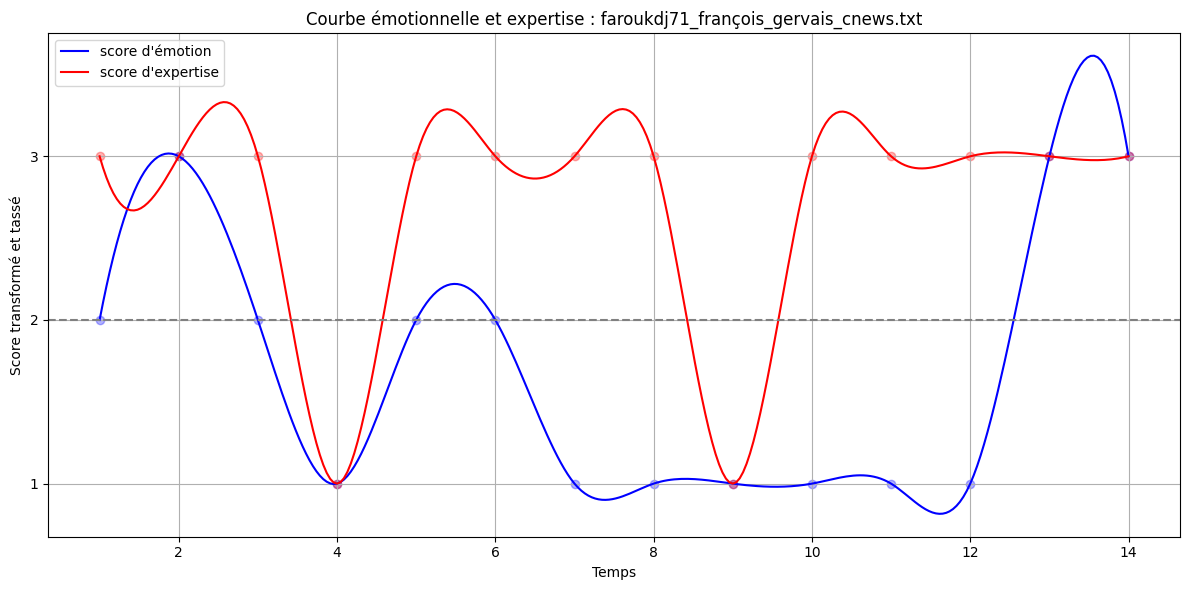

In [44]:
df_filtered = mon_fichier.replace([float('inf'), float('-inf')], np.nan)
df_filtered = df_filtered.dropna(subset=['score_vf', 'expertise_gpt4']).copy()

# --- Conversion 'score_vf' en num√©rique ---
df_filtered['score_vf'] = pd.to_numeric(df_filtered['score_vf'], errors='coerce')

# --- Filtre sur un titre pr√©cis ---
titre_exact = "faroukdj71_fran√ßois_gervais_cnews.txt" #remplacer par un titre exact (dans la colonne 'title') :
df_filtered = mon_fichier[mon_fichier['title'] == titre_exact]

# --- Suppression des NaN restants apr√®s conversion ---
df_filtered = df_filtered.dropna(subset=['score_vf'])

# --- Conversion en entier ---
df_filtered['score_vf'] = df_filtered['score_vf'].astype(int)

# --- Courbe 1 : score_vf (discret, compress√©) ---
score_mapping = {1: -0.2, 2: 0.0, 3: 0.2}
y1 = np.array([score_mapping[s] for s in df_filtered['score_vf']])

# --- Courbe 2 : expertise_gpt4 (normalisation min-max entre -0.2 et 0.2) ---
y2_raw = df_filtered['expertise_gpt4'].values.astype(float)
y2_min, y2_max = y2_raw.min(), y2_raw.max()
y2 = -0.2 + 0.4 * (y2_raw - y2_min) / (y2_max - y2_min)

# --- Axe X ---
x = np.arange(1, len(df_filtered) + 1)

# --- Lissage ---
x_smooth = np.linspace(x.min(), x.max(), 300)
spline1 = make_interp_spline(x, y1, k=3)
spline2 = make_interp_spline(x, y2, k=3)
y1_smooth = spline1(x_smooth)
y2_smooth = spline2(x_smooth)

# --- Trac√© ---
plt.figure(figsize=(12, 6))

# Courbe 1 : √©motion
plt.plot(x_smooth, y1_smooth, label="score d'√©motion", color='blue')
plt.scatter(x, y1, color='blue', alpha=0.3)

# Courbe 2 : expertise
plt.plot(x_smooth, y2_smooth, label="score d'expertise", color='red')
plt.scatter(x, y2, color='red', alpha=0.3)

# D√©corations
plt.axhline(0, color='gray', linestyle='--')
plt.title(f"Courbe √©motionnelle et expertise : {titre_exact}")
plt.xlabel("Temps")
plt.ylabel("Score transform√© et tass√©")
plt.yticks(ticks=[-0.2, 0.0, 0.2], labels=['1', '2', '3'])

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**4. quelle est la longueur moyenne des palliers pour chaque score pour l'√©motion et pour l'expertise ?**

In [52]:
def get_runs(df, col):
    # Cr√©er un groupe qui change chaque fois que la valeur de la colonne change
    group_id = (df[col] != df[col].shift()).cumsum()

    # Grouper par ces segments
    runs = df.groupby(group_id).agg(
        score=(col, 'first'),
        run_length=(col, 'size')
    ).reset_index(drop=True)

    # Ne garder que les runs d'au moins 3 √©l√©ments
    runs = runs[runs['run_length'] >= 2]

    return runs



In [53]:
all_runs_emotion = []
all_runs_expertise = []

for title, group in mon_fichier.groupby('title'):
    runs_emotion = get_runs(group, 'score_vf')
    runs_expertise = get_runs(group, 'expertise_gpt4')

    all_runs_emotion.append(runs_emotion)
    all_runs_expertise.append(runs_expertise)

df_runs_emotion = pd.concat(all_runs_emotion, ignore_index=True)
df_runs_expertise = pd.concat(all_runs_expertise, ignore_index=True)

# Calcul des moyennes
moyennes_emotion = df_runs_emotion.groupby('score')['run_length'].mean()
moyennes_expertise = df_runs_expertise.groupby('score')['run_length'].mean()


In [54]:
print("Longueur moyenne des segments √©motionnels par score :")
print(moyennes_emotion)

print("\nLongueur moyenne des segments d'expertise par score :")
print(moyennes_expertise)

Longueur moyenne des segments √©motionnels par score :
score
1    3.168421
2    3.356863
3    2.385965
Name: run_length, dtype: float64

Longueur moyenne des segments d'expertise par score :
score
1    2.914894
2    2.500000
3    3.954545
Name: run_length, dtype: float64


**5. o√π se situent les s√©quences tr√®s √©motionn√©es dans les documents qui contiennent ce type de s√©quences ?**

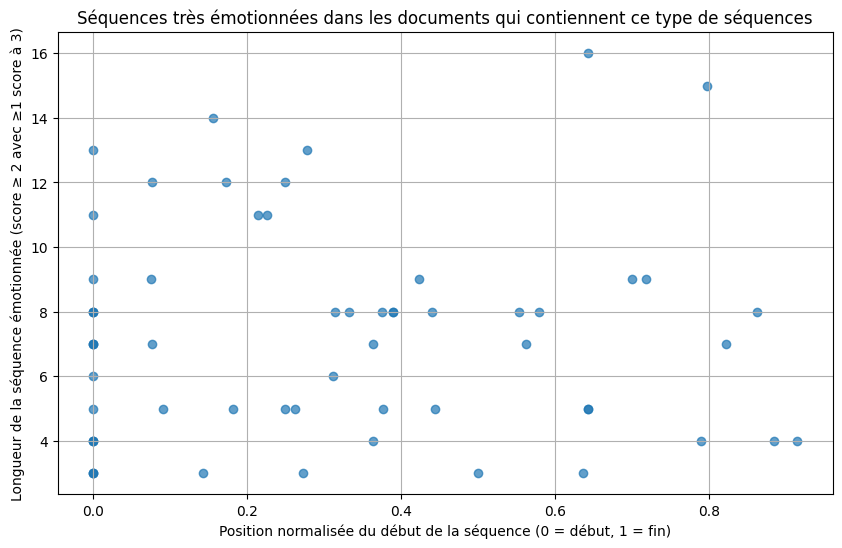

In [55]:
resultats = []

for title, group in mon_fichier.groupby("title"):
    scores = group["score_vf"].tolist()
    n = len(scores)
    if n == 0:
        continue

    scores = np.array(scores)

    max_len = 0
    max_start = -1

    i = 0
    while i < n:
        if scores[i] >= 2:
            start = i
            contains_3 = scores[i] == 3
            length = 1
            i += 1

            while i < n and scores[i] >= 2:
                if scores[i] == 3:
                    contains_3 = True
                length += 1
                i += 1

            if contains_3 and length >= 3:
                if length > max_len:
                    max_len = length
                    max_start = start
        else:
            i += 1

    if max_len == 0:
        continue

    start_norm = max_start / n
    end_norm = (max_start + max_len) / n

    resultats.append({
        "title": title,
        "max_sequence_length": max_len,
        "start_norm": start_norm,
        "end_norm": end_norm
    })

df_sequences = pd.DataFrame(resultats)

# üé® Visualisation mise √† jour
plt.figure(figsize=(10, 6))
plt.scatter(df_sequences["start_norm"], df_sequences["max_sequence_length"], alpha=0.7)
plt.xlabel("Position normalis√©e du d√©but de la s√©quence (0 = d√©but, 1 = fin)")
plt.ylabel("Longueur de la s√©quence √©motionn√©e (score ‚â• 2 avec ‚â•1 score √† 3)")
plt.title("S√©quences tr√®s √©motionn√©es dans les documents qui contiennent ce type de s√©quences")
plt.grid(True)
plt.show()

**6. Carte de chaleur montrant la combinaison des scores :**

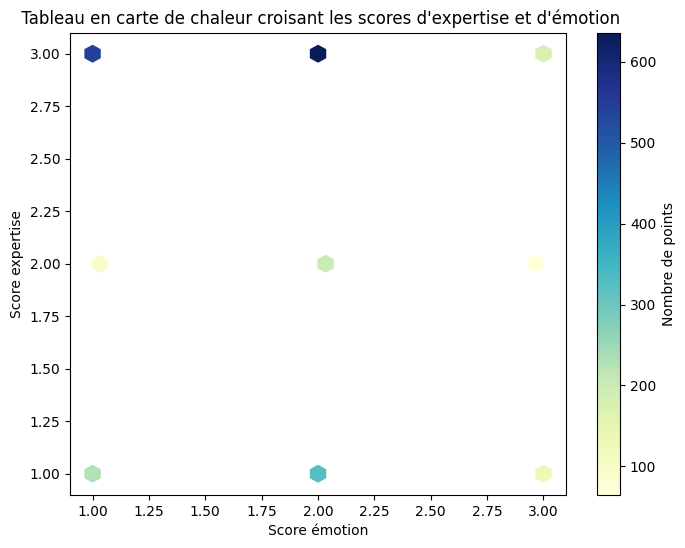

In [32]:
plt.figure(figsize=(8,6))
plt.hexbin(mon_fichier['score_vf'], mon_fichier['expertise_gpt4'], gridsize=30, cmap='YlGnBu', mincnt=1)
plt.colorbar(label='Nombre de points')
plt.xlabel('Score √©motion')
plt.ylabel('Score expertise')
plt.title(" Tableau en carte de chaleur croisant les scores d'expertise et d'√©motion")
plt.show()


## **Pour la partie sur l'analyse de l' √©motion :**

**7. On calcule les documents qui contiennent les scores √©motionnels les plus hauts :**

In [ ]:
# Seuil : ici, on consid√®re "d√©but" comme les 10% premiers du texte
seuil_debut = 0.2

# Filtrer les documents o√π la s√©quence la plus √©motionn√©e commence tr√®s t√¥t
docs_debut = df_sequences[df_sequences["start_norm"] <= seuil_debut]

# Afficher les titres
print("Documents dont le passage le plus √©motionn√© commence en d√©but de discours :")
print(docs_debut[["title", "start_norm", "max_sequence_length"]])


Documents dont le passage le plus √©motionn√© commence en d√©but de discours :
                                                title  start_norm  \
1   CLIMAT_ENQUTE_SUR_UN_MENSONGE_MONDIAL_ALBAN_D_...    0.181818   
2   DME_Maintenant_Ce_Sont_Les_Huitres_Qui_Sont_Re...    0.000000   
6   DME_Maintenant_Votre_Potager_Serait_Le_Respons...    0.142857   
10  DME_Votre_RESPIRATION_Est_Mauvaise_Pour_le_Cli...    0.076923   
12  LE_CLUB_DE_ROME_LE_GROUPE_SECRET_L_ORIGINE_DE_...    0.000000   
17  Tatiana_ventose_LA_PEUR_POUR_NOUS_ FAIRE_ACCEP...    0.172414   
18  V√©ritable_r√©chauffement_climatique_ou_prise_de...    0.000000   
19     aberkane_vers_une_dictature_climatique.txt.txt    0.075269   
20      climat_corona_et_caetera_henri_de_lesquen.txt    0.000000   
22             dme_colocation_obligatoire_en_2025.txt    0.000000   
23                        dme_l'empreinte_carbone.txt    0.000000   
27                   fab_roots_controle_du_climat.txt    0.000000   
28              farouk

## **Pour la partie qui √©tudie les chevauchements entre expertise et √©motion :**

**8. Quels passages montrent deux scores hauts, √† 3 ?**

In [56]:
df_score_eleve = mon_fichier[(mon_fichier['score_vf'] == 3) & (mon_fichier['expertise_gpt4'] == 3)]
df_score_eleve

Unnamed: 0                                              title  \
1              1      climat_corona_et_caetera_henri_de_lesquen.txt   
2              2      climat_corona_et_caetera_henri_de_lesquen.txt   
15            15      climat_corona_et_caetera_henri_de_lesquen.txt   
34            34  climat_schwab_crache_le_morceau_florian_philip...   
39            39  climat_schwab_crache_le_morceau_florian_philip...   
...          ...                                                ...   
2310        2310  tocsin_rechauffement_climatique_un_physiscien_...   
2315        2315  toscin_Le_rechauffement_climatique_est_un_nouv...   
2335        2335  toscin_Le_rechauffement_climatique_est_un_nouv...   
2373        2373                             tvl_benoit_rittaud.txt   
2397        2397     yves_roucaute_sur_cnews_raphael_dragonneau.txt   

                                                content     score  \
1     Le 26 f√©vrier 2020, le PSG a jou√© au pied √† Ly...  0.684093   
2     Le soir m√™me, jeudi 12 mars, sans plus attendr...  0.551490   
15    C'est notamment le cas pour les nuages, qui jo...  0.482279   
34    Professeur agr√©g√© de philosophie, qui est vice...  0.931207   
39    Et si vous venez √† deux, inscrivez-vous, s'il ...  0.791400   
...                                                 ...       ...   
2310  Mais mes coll√®gues chercheurs n'ont pas le tem...  0.885262   
2315  Le climat, l'√©volution du climat, le changemen...  0.536594   
2335  Et apr√®s, en tout cas, merci d'√™tre l√† ce mati...  0.862050   
2373  Je mentionne dans mon ouvrage un appel qui a √©...  0.517273   
2397  C'est absolument incroyable, c'est fascinant c...  0.743721   

      score_echelle                                    score_par_label  \
1                 2  sad: 0.1762, fear: 0.0697, anger: 0.6841, neut...   
2                 2  sad: 0.4262, fear: 0.0081, anger: 0.5515, neut...   
15                1  sad: 0.0229, fear: 0.3193, anger: 0.0470, neut...   
34                3  sad: 0.0030, fear: 0.0005, anger: 0.0004, neut...   
39                3  sad: 0.0042, fear: 0.0007, anger: 0.0010, neut...   
...             ...                                                ...   
2310              3  sad: 0.0518, fear: 0.0222, anger: 0.8853, neut...   
2315              2  sad: 0.0032, fear: 0.0024, anger: 0.0023, neut...   
2335              3  sad: 0.0042, fear: 0.0009, anger: 0.0012, neut...   
2373              2  sad: 0.5173, fear: 0.0207, anger: 0.4191, neut...   
2397              2  sad: 0.0263, fear: 0.0498, anger: 0.0366, neut...   

      sum_without_neutral  sum_recalibree label_dominant  intensite_emotion  \
1                  0.9687        7.345752          anger                  2   
2                  0.9901        5.284120          anger                  2   
15                 0.8749       28.279754       surprise                  3   
34                 0.9376       21.849069            joy                  3   
39                 0.8011       18.648715            joy                  3   
...                   ...             ...            ...                ...   
2310               0.9832        4.833768          anger                  2   
2315               0.5575       13.070159            joy                  2   
2335               0.8725       20.316180            joy                  3   
2373               0.9666        6.141685            sad                  2   
2397               0.9264       28.496339       surprise                  3   

      score_vf  expertise_gpt4  
1            3               3  
2            3               3  
15           3               3  
34           3               3  
39           3               3  
...        ...             ...  
2310         3               3  
2315         3               3  
2335         3               3  
2373         3               3  
2397         3               3  

[176 rows x 12 columns]

9. **Calculer le pourcentage de segments qui combinent des scores hauts pour les deux dimensions linguistiques √©tudi√©es :**

In [47]:
mon_fichier["score_vf"] = pd.to_numeric(mon_fichier["score_vf"], errors="coerce")
mon_fichier["expertise_gpt4"] = pd.to_numeric(mon_fichier["expertise_gpt4"], errors="coerce")

df_both3 = mon_fichier[(mon_fichier["score_vf"] == 3) & (mon_fichier["expertise_gpt4"] == 3)]

# Nombre de segments concern√©s
nb_both3 = len(df_both3)

# Nombre total de segments
nb_total = len(mon_fichier)

# Pourcentage
pourcentage = (nb_both3 / nb_total) * 100

print(f"Nombre de segments avec √©motion=3 et expertise=3 : {nb_both3}")
print(f"Nombre total de segments : {nb_total}")
print(f"Pourcentage : {pourcentage:.2f}%")

Nombre de segments avec √©motion=3 et expertise=3 : 176
Nombre total de segments : 2398
Pourcentage : 7.34%


10. **Pour visualiser le nombre de discours qui ne comprennent pas de segment annot√© 3 : **

In [49]:
# Grouper par titre et v√©rifier si au moins un segment a score=3
discours_sans_3 = mon_fichier.groupby("title")["score_vf"].apply(lambda x: (x == 3).sum() == 0)

# Comptage
nb_sans3 = discours_sans_3.sum()  # nb de discours sans aucun 3
nb_total_discours = discours_sans_3.shape[0]

# Pourcentage
pourcentage_sans3 = (nb_sans3 / nb_total_discours) * 100 if nb_total_discours > 0 else 0

print(f"Nombre de discours sans score √©motionnel = 3 : {nb_sans3}")
print(f"Nombre total de discours : {nb_total_discours}")
print(f"Pourcentage : {pourcentage_sans3:.2f}%")


Nombre de discours sans score √©motionnel = 3 : 38
Nombre total de discours : 115
Pourcentage : 33.04%


11. **Afficher aussi le nombre de discours sans score √©motionnel sans 2 ni 3 :**

In [50]:
# V√©rifier quels discours ont uniquement des scores √©motionnels = 1
discours_tout_1 = mon_fichier.groupby("title")["score_vf"].apply(lambda x: (x.astype(float) == 1).all())

# Extraire les titres
titres_tout_1 = discours_tout_1[discours_tout_1].index.tolist()

print("Titres des discours avec uniquement score √©motionnel = 1 :")
for t in titres_tout_1:
    print("-", t)

print(f"\nNombre de discours avec uniquement score √©motionnel = 1 : {len(titres_tout_1)}")


Titres des discours avec uniquement score √©motionnel = 1 :
- dme_en_direct_L'ecologie_la_Plus_Grande_Arnaque_du_Si√®cle.txt
- on_nous_aurait_menti_sur_le_co2_hacine_dz.txt

Nombre de discours avec uniquement score √©motionnel = 1 : 2
